In [57]:
import numpy as np
#from numpy.random import choice
import matplotlib.pyplot as plt
from stl import mesh
from mpl_toolkits import mplot3d

### Getting basic Cherenkov light source for chroma
Based off of Soud's code at https://github.com/soudk/phys512/blob/master/project_cherenkov/NumbaCherenkov.ipynb

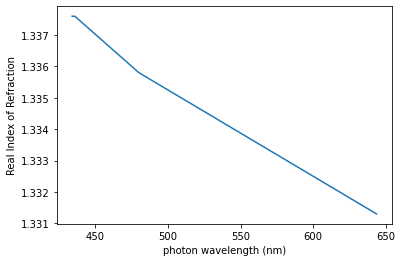

In [26]:
#In eV
energies = np.array([0.602, 0.689, 1.03,  1.926, 2.583, 2.845, 2.857, 3.124,3.457, 3.643, 3.812, 4.086, 4.511, 4.953, 5.474, 6.262, 7.000, 8.300, 10.00, 12.60])
#Refractive index of water from Segelstein, David J. The complex refractive index of water. Diss. University of Missouri--Kansas City, 1981.
n = np.array([1.303, 1.3120,   1.3239,   1.3313, 1.3358, 1.3376, 1.3376, 1.3392, 1.3423, 1.3442, 1.3460, 1.3486, 1.3540, 1.3619, 1.3723, 1.3960, 1.3960, 1.3960,1.3960, 1.3960])

#plt.plot(energies, n)

wavelengths = 1239.8/energies

freq = 3e17/wavelengths

#Only take the ~near visible range (where photomultiplier tubes are sensitive). 
#This is the tail of the Cherenkov emission spectrum.
cut = [3,7]
freq = freq[cut[0]:cut[1]]
wavelengths=wavelengths[cut[0]:cut[1]]
energies=energies[cut[0]:cut[1]]
n=n[cut[0]:cut[1]]

#radians, approx Cherenkov angle in optical (~0.5 degree precision)
thetaRel = 0.733 

plt.plot(wavelengths, n)
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Real Index of Refraction')
plt.show()

In [27]:
#Define custom data type here for particles
ptcl = np.dtype({'names':['x', 'y', 'z', 'px', 'py', 'pz', 'tracklength'], 
                 'formats':[np.double, np.double, np.double, np.double, np.double, np.double, np.double]})

In [90]:
'''
Give position, direction and length?
then can pick n number of photons along that path like here
- also momentum i guess

'''


def propagateChere_init(parentPtcl):
    
    parentMomentum = np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])
    trackLength = parentPtcl['tracklength'] 
    
    parentEntryPosition =  np.array([parentPtcl['x'], parentPtcl['y'], parentPtcl['z']])
    
    parentEndPosition = trackLength*parentMomentum + parentEntryPosition
        
    dx, dy, dz = parentEndPosition - parentEntryPosition
    
    #print(parentEntryPosition)
    #print(parentEndPosition)
#     trackLength = np.sqrt(dx*dx+dy*dy+dz*dz)
    
    #Note now the muon has moved to it's final position
    
    photonsPerCm=100 #this is set by the physics in the Frank-Tamm formula
    numPhotons = int(trackLength*photonsPerCm)
    
    photons = np.zeros(numPhotons, dtype=ptcl) #output array of photons, can't be parallelized with njit :(
    #photons=np.zeros(numPhotons)
    #assert 1==0
#     Soud used prange: 'Numba implements the ability to run loops in parallel'
    for i in range(numPhotons):
        
        numStepsAway = np.random.rand()*trackLength #pick a random point on the track
        
        #photon position
        photons[i]['x'] = parentEntryPosition[0]+numStepsAway*parentPtcl['px'] 
        photons[i]['y'] = parentEntryPosition[1]+numStepsAway*parentPtcl['py']
        photons[i]['z'] = parentEntryPosition[2]+numStepsAway*parentPtcl['pz']

        momentum=np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])

        #First, rotate relative to z axis by Cherenkov angle
        c, s = np.cos(thetaRel), np.sin(thetaRel) #cos and sine
        ux, uy, uz = np.cross(parentMomentum, [0.,0.,1.0]) #Need to rotate around axis out of page/into page
#         print(ux, uy, uz)
       
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        
#         print(R)
        
        momentum = R.dot(momentum)
        #momentum= np.dot(R, momentum)

        #Now rotate random amount of phi about axis of parent trajectory
        phi=np.random.sample()*np.pi*2.0
        c, s = np.cos(phi), np.sin(phi) #cos and sine
        ux, uy, uz = parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum)
        
        #Photon momentum set sow now leave track in a cherenkov cone 
        photons[i]['px'], photons[i]['py'], photons[i]['pz'] = momentum[0], momentum[1], momentum[2]
        
        #can get energy and therefore wavelength from momentum now here
        
        #Deal with the intersection/photon hit here
#         calc_intersect_OD_photon(photons[i])
        i+=1
        
    #Return the photon hit positions - I want just their initial positions
    return photons

In [102]:
numMuons = 1
muon = np.zeros(numMuons, dtype=ptcl)

muon['x'] = 1.0 

muon['px'] = 10.0
# muon['py'] = -10.0

muon['tracklength'] = 2.0

print(muon)

[(1., 0., 0., 10., 0., 0., 2.)]


In [103]:
photons = propagateChere_init(muon[0])

0.0 0.0 0.0


In [104]:

# print(len(photons))

# photons['x']

parentMomentum = np.array([muon[0]['px'], muon[0]['py'], muon[0]['pz']])
trackLength = muon[0]['tracklength'] 

parentEntryPosition =  np.array([muon[0]['x'], muon[0]['y'], muon[0]['z']])

parentEndPosition = trackLength*parentMomentum + parentEntryPosition

muonPath = np.array([parentEntryPosition, parentEndPosition]).T

print(muonPath)


[[ 1. 21.]
 [ 0.  0.]
 [ 0.  0.]]


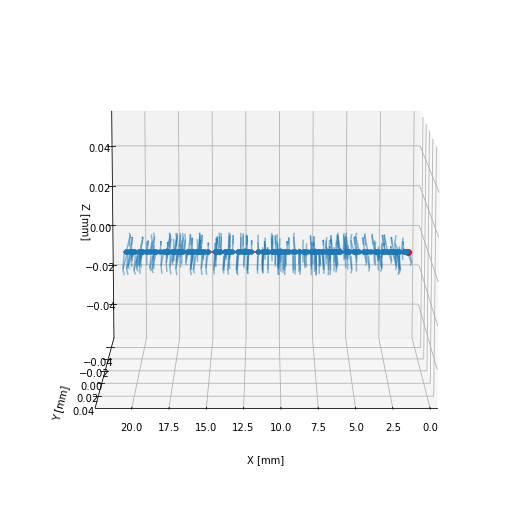

In [105]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.plot3D(muonPath[0][0], muonPath[1][0], muonPath[2][0], 'red', marker='o')

axes.plot3D(muonPath[0], muonPath[1], muonPath[2], 'red')#, alpha=0.4)

p = axes.scatter3D(photons['x'], photons['y'], photons['z'])# , c=direction, cmap='viridis') #, vmin=0, vmax=ELs_max)
Q = axes.quiver(photons['x'], photons['y'], photons['z'],photons['px'], photons['py'], photons['pz'], length=0.00005, alpha=0.5)#, normalize=True, alpha=0.5)
    
# addGeometry(axes, parts=['PMTconnect','PMTGlass', 'OC'])  #'WT' ,

# axes.set_xlim3d(-300, 300)
# axes.set_ylim3d(-300, 300)
# axes.set_zlim3d(-7400, -6930)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

# axes.legend()

# fig.colorbar(p, label="Step Number", shrink=0.8)

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(10, 90)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()